Linear Discriminant Analysis
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: Derivation and examples of [LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis).  A thorough comparison [dicriminant analysis methods](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) can be found at [All Models are Wrong](https://allmodelsarewrong.github.io/discanalysis.html) or Prof. Sebastian Raschka's [blog](https://sebastianraschka.com/Articles/2014_python_lda.html). Linear discriminant analysis (LDA) is a supervised method that can be used for classification or dimensionality reduction (often [followed by classification](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/gallery/lda.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
import imblearn

import numpy as np

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from pychemauth.preprocessing.scaling import CorrectedScaler

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

numpy     : 1.24.3
sklearn   : 1.3.0
matplotlib: 3.7.2
json      : 2.0.9
pychemauth: 0.0.0b3
watermark : 2.4.3



LDA as a classifier
---
LDA makes certain strong assumptions when functioning as a classifier:

1. The data is normally distributed,
2. The features are statistically independent,
3. Covariance matrices are identical for every class.

Why is that?  LDA can actually be derived from probabilistic models that describe the class conditional distribution of the data, namely $P(y=k|x)$, for class $k$ given $x$.

scikit-learn discusses this [here](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda-math), and more details can be found in Hastie et al. "The Elements of Statistical Learning" (2008).

From Bayes' Law we have (note this assumes $x$ is a row vector; if column format is used the transposes below will switch around):

$$P(y=k|x) = \frac{P(x|y=k)P(y=k)}{P(x)} = \frac{P(x|y=k)P(y=k)}{\sum_l P(x|y=l)P(y=l)} \sim P(x|y=k)P(y=k)$$

The denominator is a constant which can be disregarded. In LDA (and [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)) one simply chooses to model $P(x|y)$ as a multivariate Gaussian as follows:

$$P(x|y=k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}} {\rm exp}\left( -\frac{1}{2}(x-\mu_k)\Sigma_k^{-1}(x-\mu_k)^T\right)$$

where $\Sigma_k$ is the covariance matrix of class $k$ and $\mu_k$ is mean vector of class $k$; $d$ is the original dimensionality of $x$. The argument of the exponent is the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance). QDA uses the covariance matrices of each class, however, if we assume they are the same, then we can write:

$${\rm ln}P(y=k|x) = {\rm ln}P(x|y=k) + {\rm ln}P(y=k) + C = -\frac{1}{2}(x-\mu_k)\Sigma^{-1}(x-\mu_k)^T + {\rm ln}P(y=k) + C'$$

where $C'$ absorbs the constants from the Gaussian and denominator in Bayes' Law.  This can be rewritten as:

$${\rm ln}P(y=k|x) = \omega_k^Tx^T + \omega_{k,0} + C$$

where $\omega_k = \Sigma^{-1}\mu_k^T$ and $\omega_{k,0} = -\frac{1}{2}\mu_k \Sigma^{-1} \mu_k^T + {\rm ln}P(y=k)$.  Again, in practice the $C$ is neglected.  sklearn stores theses as `coef_` and `intercept_` in the LDA object.  The linear nature of this equation is why it is known as "linear" DA, vs. when we make no assumptions about $\Sigma$ being equal for all classes, the result is quadratice, hence QDA.

Consequently, the above decision function can be computed (see `sklearn.discrimininant_analysis.LinearDiscriminantAnalysis.decision_function`) to provide the log probability of a given class.  Normalizing over all classes gives the `sklearn.discrimininant_analysis.LinearDiscriminantAnalysis.predict_proba` result, or the ability to predict the class probability.  LDA assigns a point to a class which it is closest to in terms of Mahalanobis distance.

Estimating the covariance matrix
---

The assumption in LDA is that the covariance matrix is the same for each class, but how do we actually measure this?  In practice, this is done by a (de-biased) weighted average (i.e., the [pooled variance](https://en.wikipedia.org/wiki/Pooled_variance)) of each class' covariance matrix.

$$\Sigma = \frac{\sum_{i=1}^k(N_i-1)\Sigma_k}{\sum_{i=1}^k(N_i-1)}$$

See this [stackexchange question](https://stats.stackexchange.com/questions/90615/estimating-the-covariance-matrix-in-linear-discriminant-analysis).  Note that sklearn can accommodate [other estimation methods](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis), though.


<h3>Implement the Algorithm</h3>

In [5]:
def lda_ln_prob(X_test, X_train, y_train):
    """Compute the lnP of classes based on LDA model of data."""

    # Assume that we are comparing to LDA using pre-scaled data
    scaler = CorrectedScaler(with_mean=True, with_std=True)
    X_train = scaler.fit_transform(X_train)

    # Encode classes an integers and transform
    enc = LabelEncoder()
    y_train = enc.fit_transform(y_train.ravel())
    
    # Identify the empirical means for each class
    means = {}
    for c in [enc.transform([class_])[0] for class_ in enc.classes_]:
        mask = y_train == enc.inverse_transform([c])[0]
        means[c] = np.mean(X_train[mask], axis=0)

    # Compute pooled covariance estimate
    sigma = np.zeros((X_train.shape[1], X_train.shape[1]))
    for c in [enc.transform([class_])[0] for class_ in enc.classes_]:
        mask = y_train == enc.inverse_transform([c])[0]
        N = np.sum(mask)
        sigma += (N-1)*np.cov(X_train[mask].T)
    sigma /= (X_train.shape[0] - len(np.unique(y_train)))

    # lda.coef_
    coef = []
    for c in [enc.transform([class_])[0] for class_ in enc.classes_]:
        coef.append(np.matmul(np.linalg.inv(sigma), means[c].T))

    # lda.intercept_
    intercept = []
    for c in [enc.transform([class_])[0] for class_ in enc.classes_]:
        intercept.append(-0.5*np.matmul(np.matmul(means[c], np.linalg.inv(sigma)), means[c].T)+np.log(np.sum(y_train==enc.inverse_transform([c])[0])/X_train.shape[0]))

    # Predict on test set
    d = X_train.shape[1]
    probs = np.zeros((X_test.shape[0], len(enc.classes_)))
    for i,x in enumerate(scaler.transform(X_test)):
        for j in [enc.transform([class_])[0] for class_ in enc.classes_]:
            probs[i,j] = np.dot(coef[j], x) + intercept[j] # Constants related to Gaussian prefactor are ignored in sklearn

    return probs, coef, intercept

In [6]:
# Let's make some sample data
X, Y = sklearn.datasets.make_blobs(
    n_samples=100,
    n_features=2,
    centers=3,
    cluster_std=.5,
    shuffle=True,
    random_state=0
)

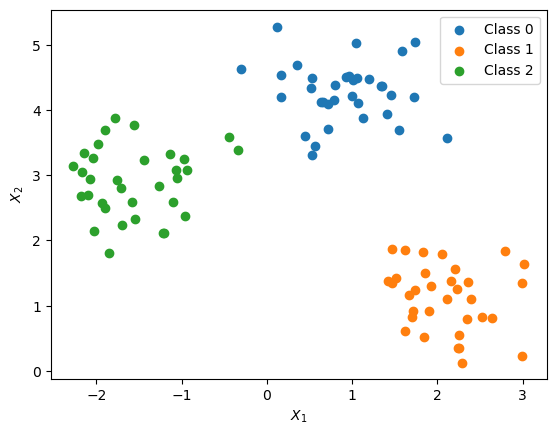

In [7]:
for class_ in np.unique(Y):
    X_ = X[Y == class_]
    plt.scatter(X_[:,0], X_[:,1], label=f'Class {class_}')
plt.legend(loc='best')
plt.xlabel(r'$X_1$')
_ = plt.ylabel(r'$X_2$')

In [8]:
# For this example we will use the entire dataset for training

scaler = CorrectedScaler()
lda = LDA(n_components=1, store_covariance=True)
_ = lda.fit(scaler.fit_transform(X), Y)

In [9]:
my_ln_probs, coef, intercept = lda_ln_prob(X, X, Y.reshape(-1,1))
sklearn_ln_probs = lda.decision_function(scaler.transform(X))

# To prevent overflow
my_shifted_probas = (my_ln_probs.T - np.max(my_ln_probs, axis=1)).T

my_probas = (np.exp(my_shifted_probas).T/np.sum(np.exp(my_shifted_probas), axis=1)).T
sklearn_probas = lda.predict_proba(scaler.transform(X))

In [10]:
assert np.allclose(my_ln_probs, sklearn_ln_probs) # Manual decision function agrees with sklearn
assert np.allclose(my_probas, sklearn_probas) # Manual class probability agrees with sklearn
assert np.allclose(lda.coef_, coef) # Manual coef agrees with sklearn
assert np.allclose(lda.intercept_, intercept) # Manual intercept agrees with sklearn

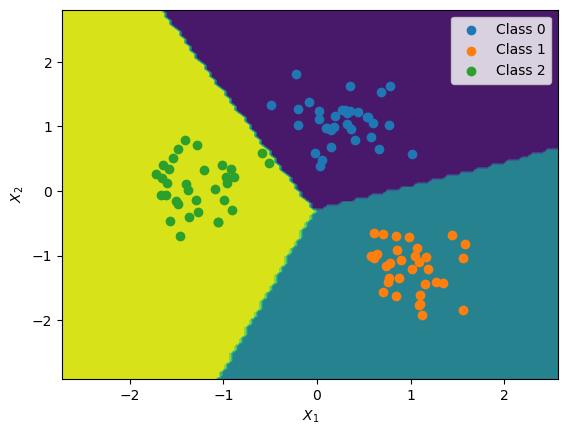

In [11]:
disp = DecisionBoundaryDisplay.from_estimator(lda, scaler.transform(X))

for class_ in np.unique(Y):
    X_ = scaler.transform(X)[Y == class_]
    disp.ax_.scatter(X_[:,0], X_[:,1], label=f'Class {class_}')
disp.ax_.legend(loc='best')
disp.ax_.set_xlabel(r'$X_1$')
_ = disp.ax_.set_ylabel(r'$X_2$')

<h3>Impact of Class Imbalance</h3>

Observe that the constant in the discriminant function involves a term ${\rm ln}P(y=k)$.  This comes from the prior in the first equation (Bayes' Law).  This is absorbed in the `intercept_` and may be relative weak compared to other terms, but it is nonetheless a factor in determining the boundary.

In [12]:
def make_imblance(factor=10):
    X, Y = sklearn.datasets.make_blobs(
        n_samples=500,
        n_features=2,
        centers=2,
        cluster_std=1,
        shuffle=True,
        random_state=0
    )

    # Let's remove a fraction of class 0 relative to the others
    mask = Y == 0

    X_ = X[~mask]
    Y_ = Y[~mask]

    X_ = np.vstack((X_, X[mask][:np.sum(mask)//factor]))
    Y_ = np.concatenate((Y_, Y[mask][:np.sum(mask)//factor]))
    
    return X_, Y_

def visualize(lda, scaler, X, Y, ax):
    disp = DecisionBoundaryDisplay.from_estimator(lda, X, ax=ax, response_method='predict')

    for class_ in np.unique(Y):
        X_ = X[Y == class_]
        disp.ax_.scatter(X_[:,0], X_[:,1], label=f'Class {class_}')
    disp.ax_.legend(loc='best')
    disp.ax_.set_xlabel(r'$X_1$')
    disp.ax_.set_ylabel(r'$X_2$')

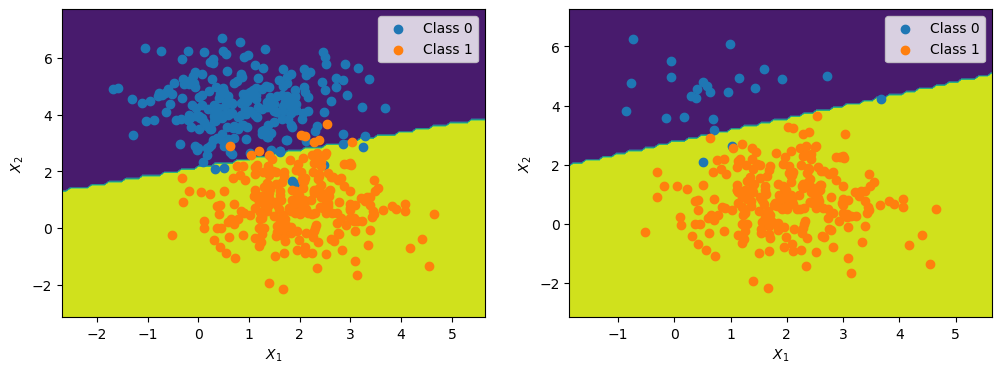

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# Balanced
X_, Y_ = make_imblance(factor=1)
scaler = CorrectedScaler()
lda = LDA(n_components=1, store_covariance=True)
_ = lda.fit(X_, Y_)

visualize(lda, scaler, X_, Y_, ax=axes[0])

# Imbalanced
X_, Y_ = make_imblance(factor=10)
scaler = CorrectedScaler()
lda = LDA(n_components=1, store_covariance=True)
_ = lda.fit(X_, Y_)

visualize(lda, scaler, X_, Y_, ax=axes[1])

LDA as a dimensionality reduction technique
---
According to [Wikipedia](https://en.wikipedia.org/wiki/Linear_discriminant_analysis):
    
> "Linear discriminant analysis (LDA), normal discriminant analysis (NDA), or discriminant function analysis is a generalization of Fisher's linear discriminant, a method used in statistics and other fields, to find a linear combination of features that characterizes or separates two or more classes of objects or events. The resulting combination may be used as a linear classifier, or, more commonly, for dimensionality reduction before later classification. "

Prof. Sebastian Raschka has a nice discussion [here](https://sebastianraschka.com/Articles/2014_python_lda.html) with illustrations in python.

> "It should be mentioned that LDA assumes normal distributed data, features that are statistically independent, and identical covariance matrices for every class. However, this only applies for LDA as classifier and LDA for dimensionality reduction can also work reasonably well if those assumptions are violated."

With [PCA](pca_pcr.ipynb), we found the orthogonal principal components that characterized the spread of the data, i.e., the covariance of X with itself (unsupervised).  With [PLS](pls.ipynb), we looked for directions that characterized the covariance of X and Y (supervised).  LDA is a supervised method which instead looks for axes that **maximize the separation between labelled classes**.  This is done by finding the eigenvectors of the matrix $S_W^{-1}S_B$, where $S_W$ is the within-class scatter matrix and $S_B$ is the between-class scatter matrix.  LDA for dimensionality reduction can be described in 5 steps:

1. Compute the p-dimensional mean vectors for all classes from the dataset.

2. Compute the scatter matrices (between-class and within-class scatter matrix).

3. Compute the eigenvectors and eigenvalues for these matrices.

4. Sort the eigenvectors by decreasing eigenvalue and choose the first $k$ eigenvectors; stack these columns to form a $p \times k$ dimensional matrix $W$.

5. Use this $p \times k$ matrix to project the samples into the new subspace by performing matrix multiplication: $T = XW$, where $T$ are the "x-scores".

PCA can be used to perform dimensionality reduction by only selecting the leading $k$ eigenvectors from the covariance matrix; assuming it is full rank, we have as many dimensions as the size of that matrix.  However, in LDA, the matrix $S_W^{-1}S_B$ will only have at most ${\rm min}(p, c-1)$ non-zero eigenvectors where $p$ is the number of features and $c$ is the number of classes.  Thus, if we want to separate 2 classes, LDA will only be able to return the single axes that separates the best.  In such a case, it might be better to even do PCA if we desire a low, but higher than 1-, dimensional result.

In general though, the **intuitive explanation for LDA is that it finds the orthogonal axes that best separate classes**.  Thus, it is a very useful dimensionality reduction approach for classification.  It is particularly helpful in identifying a subspace that is highly discriminative, in which other models can be used to compute decision boundaries.  For example, a pipeline might look like:

1. Standardize data
2. LDA to project into a small number of dimensions
3. Use logistic regression to classify

In [14]:
data = sklearn.datasets.load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, train_size=0.8, random_state=0)

In [15]:
# Scale and perform LDA to project into 2D
scaler = CorrectedScaler()
lda = LDA(n_components=2)
X_train_std_lda = lda.fit_transform(scaler.fit_transform(X_train), y_train)

In [16]:
# Train a LR classifier in that 2D space
lr = LogisticRegression(C=1.0, random_state=0)
_ = lr.fit(X_train_std_lda, y_train)

Text(0, 0.5, 'LDA Component 2')

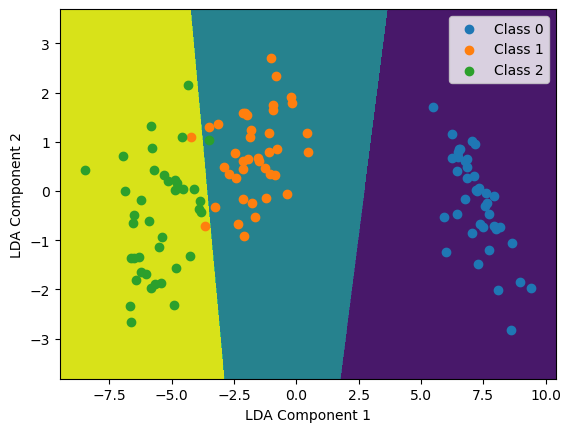

In [17]:
disp = DecisionBoundaryDisplay.from_estimator(lr, X_train_std_lda, response_method='predict', grid_resolution=1000)

for class_ in np.unique(y_train):
    X_ = X_train_std_lda[y_train == class_]
    disp.ax_.scatter(X_[:,0], X_[:,1], label=f'Class {class_}')
disp.ax_.legend(loc='best')
disp.ax_.set_xlabel(r'LDA Component 1')
disp.ax_.set_ylabel(r'LDA Component 2')

You can see that the decision boundaries along the first component axis (x-axis) are **nearly vertical** - this is because LDA finds the axes that best separate the classes from each other as you move along it.  The data here is particularly amenable to this approach.

In [18]:
pipe = Pipeline([
    ('scaler', CorrectedScaler()),
    ('lda', LDA()),
    ('lr', LogisticRegression(random_state=0))
]
)

grid = [
    {'lda__n_components':[1,2], # Limited to n_classes-1
     'lr__C':np.logspace(-5,0,10),
    }
]

gs = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    refit=True,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=0),
    n_jobs=-1
)
_ = gs.fit(X_train, y_train)

In [19]:
gs.best_params_

{'lda__n_components': 2, 'lr__C': 0.2782559402207126}

In [20]:
gs.score(X_test, y_test)

1.0